**Описание проекта**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.   
**Задача проекта:** Вам нужно построить модель для определения стоимости.  
Заказчику важны:    
* качество предсказания;
* скорость предсказания;
* время обучения.

**Описание данных**  

Признаки  

`DateCrawled` — дата скачивания анкеты из базы  
`VehicleType` — тип автомобильного кузова  
`RegistrationYear` — год регистрации автомобиля  
`Power` — мощность (л. с.)  
`Model` — модель автомобиля  
`Kilometer` — пробег (км)  
`RegistrationMonth` — месяц регистрации автомобиля  
`FuelType` — тип топлива  
`Brand` — марка автомобиля  
`Repaired` — была машина в ремонте или нет  
`DateCreated` — дата создания анкеты  
`NumberOfPictures` — количество фотографий автомобиля  
`PostalCode` — почтовый индекс владельца анкеты (пользователя)  
`LastSeen` — дата последней активности пользователя 

Целевой признак

`Price` — цена (евро)  

## Загрузка данных

In [1]:
pip install catboost


[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool, cv
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv(r'C:\Users\79119\Desktop\DF\autos_price\autos.csv')

In [4]:
def df_info(df):
    print('Выгрузка таблицы')
    display(df.head())
    print(' ')
    print('Общая информация')
    print(df.info())
    print(' ')
    print('Пропуски')
    print(df.isna().sum())
    print(' ')
    print('Дубликаты')
    print(df.duplicated().sum())
    print(' ')
    print('Статистика')
    display(df.describe())


In [5]:
df_info(df)

Выгрузка таблицы


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


 
Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
import re
new_columns = []
for column in df.columns:
    # имя колонки в строке
    c = column
    # имя колонки в списке
    cl = list(column)
    
    points_of_start = []
    # ищем индексы вхождения больших букв и сохраняем их в список
    for match in re.finditer("[A-Z]", c):
        points_of_start.append(match.start())
    
    # преобразовываем название колонки на основании найденных индексов
    for symbol in points_of_start[:0:-1]:
        cl.insert(symbol, '_')
        
    new_columns.append(''.join(cl).lower())
    
df.columns = new_columns

In [7]:
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Посмотрим на выбросы в  признаках `power` и `registration_year`

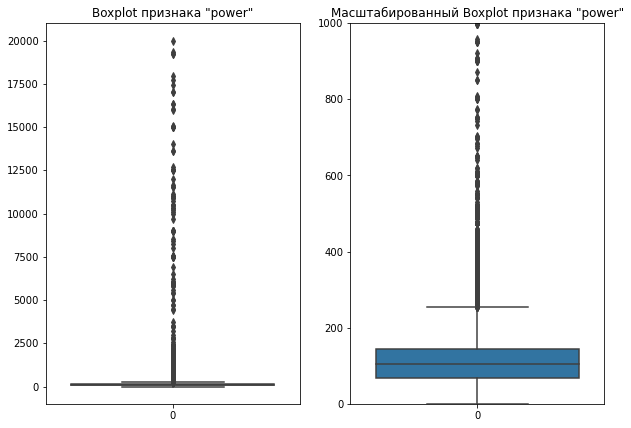

In [8]:
plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
sns.boxplot(data=df['power'])
plt.title('Boxplot признака "power"')
plt.subplot(1, 2, 2)
sns.boxplot(data=df['power'])
plt.ylim(0, 1000)
plt.title('Масштабированный Boxplot признака "power"')
plt.show()

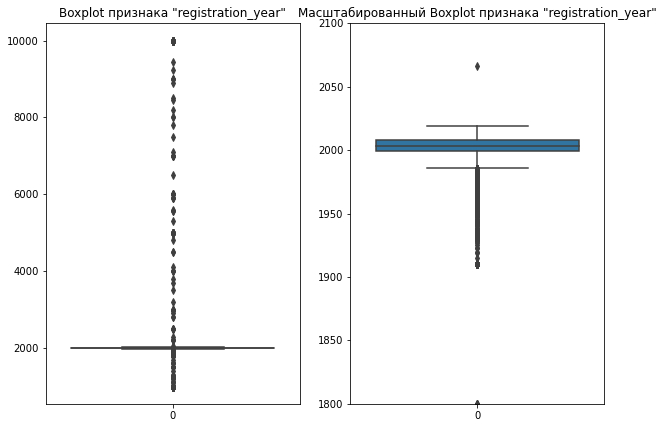

In [9]:
plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
sns.boxplot(data = df['registration_year'])
plt.title('Boxplot признака "registration_year"')
plt.subplot(1, 2, 2)
sns.boxplot(data = df['registration_year'])
plt.ylim(1800, 2100)
plt.title('Масштабированный Boxplot признака "registration_year"')
plt.show()

# Вывод:
Загружена таблица размером 354369 строк и 16 столбцов из которых 7 типа int и 9 типа object. В столбцах `vehicle_type`, `gearbox`, `model`, `fuel_type`, `not_repaired` присутствует значительное количество пропусков. Также в датафрейме имеется 4 дубликата. Признаки `price`, `registration_year` и `power` имеют выбросы.

## Предобработка

In [10]:
data = df.copy()

In [11]:
data['vehicle_type'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64

In [12]:
data['model'].value_counts().head(20)

golf           29232
other          24421
3er            19761
polo           13066
corsa          12570
astra          10809
passat         10146
a4              9900
c_klasse        8312
5er             7868
e_klasse        6785
a3              6122
focus           5874
fiesta          5774
a6              5541
twingo          4953
transporter     4822
2_reihe         4816
fortwo          4337
vectra          4254
Name: model, dtype: int64

In [13]:
data['fuel_type'].value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

Т.к. в столбцах `vehicle_type`, `model` и `fuel_type` присутствует категория other, то к ней мы отнесем и пропуски в данных столбцах. А пропуски в `gearbox` и `repaired` заполнили значение unknown.

In [14]:
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [15]:
data['vehicle_type'] = data['vehicle_type'].fillna('other')
data['model'] = data['model'].fillna('other')
data['fuel_type'] = data['fuel_type'].fillna('other')
data['gearbox'] = data['gearbox'].fillna('unknown')
data['repaired'] = data['repaired'].fillna('unknown')

In [16]:
data.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

Минимальная мощность автомобиля состаляет 4.2 л.с., а максимально возможная 1500 л.с. Следовательно в столбце `power` значения, которые менее 4.2 л.с. (40308 шт.) заполним медианным значением, сгруппированным по марке, модели и году регистрации (в разные года у одних и тех же моделей может меняться двигатель). После этого избавимся от выбросов, которые мегьше 4.2 и больше 1500.

In [17]:
print('Количество наблюдений с power меньше 4.2 л.с.:', data[data['power'] < 4.2]['power'].count())
print('Количество наблюдений с power больше 1500 л.с.:', data[data['power'] > 1500]['power'].count())

Количество наблюдений с power меньше 4.2 л.с.: 40308
Количество наблюдений с power больше 1500 л.с.: 203


In [18]:
data.loc[data['power'] < 4.2, 'power'] = data.groupby(['brand', 'model', 'registration_year'])['power'].transform('median')
data[data['power'] < 4.2]['power'].count()

3104

In [19]:
data= data.query('4.2 < power <= 1500')
data['power'].describe()

count    351062.000000
mean        118.184081
std          57.257285
min           5.000000
25%          75.000000
50%         109.000000
75%         143.000000
max        1500.000000
Name: power, dtype: float64

In [20]:
data['date_created'].max()

'2016-04-07 00:00:00'

In [21]:
print('Количество наблюдений с годом регистарации меньшим, чем 1950:', data[data['registration_year']<=1950]['registration_year'].count())
print('Количество наблюдений с годом регистарации большим, чем 2016:', data[data['registration_year']>=2016]['registration_year'].count())

Количество наблюдений с годом регистарации меньшим, чем 1950: 87
Количество наблюдений с годом регистарации большим, чем 2016: 23532


In [22]:
data = data.query('2016 >= registration_year >= 1950')
data['registration_year'].describe()

count    336850.000000
mean       2002.594609
std           6.676913
min        1950.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64

In [23]:
data['price'].describe()

count    336850.000000
mean       4493.019193
std        4547.278035
min           0.000000
25%        1100.000000
50%        2800.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

In [24]:
print('Количество наблюдений со стоимостью равной 0:', data[data['price'] == 0]['price'].count())

Количество наблюдений со стоимостью равной 0: 9286


In [25]:
data = data.query('price != 0')

In [26]:
data = data.drop_duplicates().reset_index(drop=True)

In [27]:
data.duplicated().sum()

0

In [28]:
data['registration_month'].value_counts()

3     32593
6     29675
0     28243
4     27588
5     27484
7     25691
10    24751
11    22950
12    22838
9     22612
1     21772
8     21299
2     20064
Name: registration_month, dtype: int64

In [29]:
data['date_crawled'].agg(['min', 'max'])

min    2016-03-05 14:06:22
max    2016-04-07 14:36:58
Name: date_crawled, dtype: object

In [30]:
data['date_created'].agg(['min', 'max'])

min    2014-03-10 00:00:00
max    2016-04-07 00:00:00
Name: date_created, dtype: object

In [31]:
print(f'Потеря данных составляет: {(df.shape[0] - data.shape[0]) / df.shape[0]:.2%}') 

Потеря данных составляет: 7.57%


In [32]:
data = data.drop(['date_crawled', 'last_seen', 'number_of_pictures', 'date_created', 'postal_code'], axis=1)

In [33]:
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
0,480,other,1993,manual,75.0,golf,150000,0,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190.0,other,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,no


In [34]:
data.isna().sum()

price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
dtype: int64

# Вывод:  
1. Т.к. в столбцах `vehicle_type`, `model` и `fuel_type` присутствует категория other, то к ней мы отнесем и пропуски в данных столбцах. А пропуски в `gearbox` и `not_repaired` заполнили значение unknown. Образование пропусков как и значения 0 в столбце `registration_month` вероятней всего связаны незаполнением данных граф в анкете при регистрации объявления.  
2. Минимальная мощность автомобиля состаляет 4.2 л.с., а максимально возможная 1500 л.с. Следовательно в столбце `power` значения, которые менее 4.2 л.с. (40308 шт.) заполним медианным значением, сгруппированным по марке, модели и году регистрации (в разные года у одних и тех же моделей может меняться двигатель). После этого избавимся от выбросов, которые мегьше 4.2 и больше 1500.  
3. Год создания первого серийного автомобиля 1885, а максимальная дата размещения объявления 07.04.2016г. Соответственно все значения которые меньше 1885 и больше или равно 2016 в столбце `registration_year`, чтобы не исказить результаты дальгейшего исследования. Тоже самое сделаем и с нулевыми значениями в столбце `price`  
4. Столбцы `date_crawled`, `last_seen`, `number_of_pictures` и `date_created` не несут како-либо важной информации поэтому избавились от них.

## Подготовка

In [35]:
data_1 = data.copy()

In [36]:
category = list(data_1.select_dtypes(include = 'object'))
numeric = list(data_1.select_dtypes( exclude = 'object'))
numeric.remove('price')

### OrdinalEncoder

In [37]:
encoder = OrdinalEncoder()

In [38]:
data_ord = pd.DataFrame(encoder.fit_transform(data_1[category]), columns = data_1[category].columns)

In [39]:
data_ord

,vehicle_type,gearbox,model,fuel_type,brand,repaired
0,3.0,1.0,116.0,6.0,38.0,1.0
1,2.0,1.0,166.0,2.0,1.0,2.0
2,6.0,0.0,117.0,2.0,14.0,1.0
3,5.0,1.0,116.0,6.0,38.0,0.0
4,5.0,1.0,101.0,2.0,31.0,0.0
...,...,...,...,...,...,...
327555,4.0,1.0,140.0,6.0,30.0,2.0
327556,0.0,1.0,248.0,6.0,24.0,0.0
327557,1.0,0.0,106.0,6.0,32.0,0.0
327558,0.0,1.0,223.0,2.0,38.0,0.0


In [40]:
df_ord = data_1.drop(columns = category, axis=1).join(data_ord)

In [41]:
df_ord.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327560 entries, 0 to 327559
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               327560 non-null  int64  
 1   registration_year   327560 non-null  int64  
 2   power               327560 non-null  float64
 3   kilometer           327560 non-null  int64  
 4   registration_month  327560 non-null  int64  
 5   vehicle_type        327560 non-null  float64
 6   gearbox             327560 non-null  float64
 7   model               327560 non-null  float64
 8   fuel_type           327560 non-null  float64
 9   brand               327560 non-null  float64
 10  repaired            327560 non-null  float64
dtypes: float64(7), int64(4)
memory usage: 27.5 MB


In [42]:
df_ord.head()

,price,registration_year,power,kilometer,registration_month,vehicle_type,gearbox,model,fuel_type,brand,repaired
0,480,1993,75.0,150000,0,3.0,1.0,116.0,6.0,38.0,1.0
1,18300,2011,190.0,125000,5,2.0,1.0,166.0,2.0,1.0,2.0
2,9800,2004,163.0,125000,8,6.0,0.0,117.0,2.0,14.0,1.0
3,1500,2001,75.0,150000,6,5.0,1.0,116.0,6.0,38.0,0.0
4,3600,2008,69.0,90000,7,5.0,1.0,101.0,2.0,31.0,0.0


In [43]:
data.shape[0]-df_ord.shape[0]

0

In [44]:
features_train, features_test, target_train, target_test = train_test_split(df_ord.drop('price', axis=1), df_ord.price, test_size=0.25, random_state=42)

In [45]:
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(245670, 10)
(245670,)
(81890, 10)
(81890,)


In [46]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [47]:
features_train.head()

,registration_year,power,kilometer,registration_month,vehicle_type,gearbox,model,fuel_type,brand,repaired
48904,0.802488,0.722295,-1.299425,1.677363,7.0,0.0,28.0,6.0,1.0,0.0
36756,-1.009253,-0.367384,0.580184,0.314458,7.0,1.0,166.0,6.0,35.0,0.0
307688,0.500532,0.898049,0.580184,1.677363,0.0,1.0,36.0,2.0,30.0,1.0
30625,0.651510,0.177455,-0.091105,-0.503285,4.0,0.0,44.0,6.0,36.0,0.0
98798,-0.103382,0.036852,0.580184,-1.593609,7.0,1.0,17.0,6.0,19.0,1.0


### OHE

In [48]:
data_2 = data.copy()

In [49]:
data_ohe = pd.get_dummies(data_2, drop_first=True)
data_ohe.head()

,price,registration_year,power,kilometer,registration_month,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
0,480,1993,75.0,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
1,18300,2011,190.0,125000,5,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163.0,125000,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75.0,150000,6,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69.0,90000,7,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [50]:
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327560 entries, 0 to 327559
Columns: 309 entries, price to repaired_yes
dtypes: float64(1), int64(4), uint8(304)
memory usage: 107.5 MB


In [51]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327560 entries, 0 to 327559
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               327560 non-null  int64  
 1   vehicle_type        327560 non-null  object 
 2   registration_year   327560 non-null  int64  
 3   gearbox             327560 non-null  object 
 4   power               327560 non-null  float64
 5   model               327560 non-null  object 
 6   kilometer           327560 non-null  int64  
 7   registration_month  327560 non-null  int64  
 8   fuel_type           327560 non-null  object 
 9   brand               327560 non-null  object 
 10  repaired            327560 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 27.5+ MB


In [52]:
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(data_ohe.drop('price', axis=1),
                                                                                            data_ohe.price, 
                                                                                            test_size=0.25, 
                                                                                            random_state=42)

In [53]:
scaler_ohe = StandardScaler()
scaler_ohe.fit(features_train_ohe[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

In [54]:
def grid(model, params, scoring, features, target):
    grid = GridSearchCV(model, params, scoring=scoring, n_jobs=-1).fit(features, target)
    return grid.best_params_, grid.best_score_

In [55]:
def random(model, params, scoring, features, target):
    random = RandomizedSearchCV(model, params, scoring=scoring, n_jobs=-1).fit(features, target)
    return random.best_params_, random.best_score_

# Вывод:  
Подготовили два набора данных: один техникой OrdinalEncoder и второй One Hot Encoder для дальнейшего сравнения.

## Обучение моделей

### LinearRegression

#### LinearRegression OrdinalEncoder

In [56]:
%%time
model_lr_ord = LinearRegression()
model_lr_ord.fit(features_train, target_train)

Wall time: 162 ms


LinearRegression()

In [57]:
%%time
pred_lr_ord = model_lr_ord.predict(features_train)

Wall time: 12 ms


In [58]:
rmse_lr_ord = mean_squared_error(target_train, pred_lr_ord)**0.5
print(f'RMSE линейной регресси: {rmse_lr_ord:.2f}')

RMSE линейной регресси: 3055.65


#### CV LinearRegression OrdinalEncoder

In [59]:
%%time
cv_lr_ord = cross_val_score(LinearRegression(),
                        features_train,
                        target_train,
                        scoring='neg_root_mean_squared_error').mean()
print(f'RMSE линейной регрессии после кросс-валидации: {cv_lr_ord*-1:.2f}')

RMSE линейной регрессии после кросс-валидации: 3056.19
Wall time: 492 ms


#### LinearRegression OHE

In [60]:
%%time
model_lr_ohe = LinearRegression().fit(features_train_ohe, target_train_ohe)

Wall time: 5.33 s


In [61]:
%%time
pred_lr_ohe = model_lr_ohe.predict(features_train_ohe)

Wall time: 511 ms


In [62]:
rmse_lr_ohe = mean_squared_error(target_train_ohe, pred_lr_ohe)**0.5
print(f'RMSE линейной регресси: {rmse_lr_ohe:.2f}')

RMSE линейной регресси: 2686.72


#### CV LinearRegression OHE

In [63]:
%%time
cv_lr_ohe = cross_val_score(LinearRegression(),
                            features_train_ohe,
                            target_train_ohe,
                            scoring='neg_root_mean_squared_error').mean()
print(f'RMSE линейной регрессии после кросс-валидации: {cv_lr_ohe*-1:.2f}')

RMSE линейной регрессии после кросс-валидации: 2690.98
Wall time: 24.5 s


### DecisionTreeRegressor

#### DecisionTreeRegressor OrdinalEncoder

In [64]:
model_dt = DecisionTreeRegressor(random_state=42)
params_tree = {'max_depth': range(1,5)}

In [65]:
# grid(model_dt, params_tree, 'neg_root_mean_squared_error', features_train, target_train)

In [66]:
# grid(model_dt, params_tree, 'neg_root_mean_squared_error', features_train_ohe,  target_train_ohe)


In [67]:
%%time
model_tree_ord = DecisionTreeRegressor(random_state=42, max_depth=4)
model_tree_ord.fit(features_train, target_train)

Wall time: 311 ms


DecisionTreeRegressor(max_depth=4, random_state=42)

In [68]:
%%time
pred_tree_ord = model_tree_ord.predict(features_train)

Wall time: 21 ms


In [69]:
rmse_tree_ord = mean_squared_error(target_train, pred_tree_ord)**0.5
print(f'RMSE модели дерево решений: {rmse_tree_ord:.2f}')

RMSE модели дерево решений: 2593.86


#### DecisionTreeRegressor OHE

In [70]:
%%time
model_tree_ohe = DecisionTreeRegressor(max_depth=4, random_state=42).fit(features_train_ohe, target_train_ohe)

Wall time: 2.84 s


In [71]:
%%time
pred_tree_ohe = model_tree_ohe.predict(features_train_ohe)

Wall time: 421 ms


In [72]:
rmse_tree_ohe = mean_squared_error(target_train_ohe, pred_tree_ohe)**0.5
print(f'RMSE модели дерево решений: {rmse_tree_ohe:.2f}')

RMSE модели дерево решений: 2593.86


### LightGBM

In [73]:
df_cat = data.copy()

In [74]:
cat = list(df_cat.select_dtypes(include='object'))

In [75]:
for col in cat:
    df_cat[col] = df_cat[col].astype('category')

In [76]:
features_train_cat, features_test_cat, target_train_cat, target_test_cat = train_test_split(df_cat.drop('price', axis=1),
                                                                                            df_cat['price'],
                                                                                            test_size = 0.25,
                                                                                            random_state=42)

In [77]:
model_grid_lgb = lgb.LGBMRegressor(random_state=42)
params_random_lgb = {"n_estimators": range(50, 200, 10),
                     "max_depth": range(1, 10, 2),
                     "num_leaves": range(1, 40, 5)}

In [78]:
# random(model_grid_lgb, params_random_lgb, 'neg_root_mean_squared_error', features_train_cat, target_train_cat)

In [79]:
# params_grid_lgb = {"n_estimators": range(135, 145, 1),
#               "max_depth": range(7, 11, 1),
#               "num_leaves": range(28, 35, 1)}

In [80]:
# grid(model_grid_lgb, params_grid_lgb, 'neg_root_mean_squared_error', features_train_cat, target_train_cat)

In [81]:
%%time
model_lgb = lgb.LGBMRegressor(max_depth=9, 
                                  n_estimators=130, 
                                  num_leaves=31, 
                                  random_state=42)
model_lgb.fit(features_train_cat, target_train_cat, eval_metric="rmse", categorical_feature='auto')

Wall time: 1.59 s


LGBMRegressor(max_depth=9, n_estimators=130, random_state=42)

In [82]:
%%time
pred_lgb = model_lgb.predict(features_train_cat)

Wall time: 742 ms


In [83]:
rmse_lgb = mean_squared_error(target_train_cat, pred_lgb)**0.5
print(f'RMSE модели LightGBM: {rmse_lgb:.2f}')

RMSE модели LightGBM: 1560.82


#### LightGBM OrdinalEncoder

In [84]:
for col in category:
    df_ord[col] = df_ord[col].astype('category')

In [85]:
df_ord.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327560 entries, 0 to 327559
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   price               327560 non-null  int64   
 1   registration_year   327560 non-null  int64   
 2   power               327560 non-null  float64 
 3   kilometer           327560 non-null  int64   
 4   registration_month  327560 non-null  int64   
 5   vehicle_type        327560 non-null  category
 6   gearbox             327560 non-null  category
 7   model               327560 non-null  category
 8   fuel_type           327560 non-null  category
 9   brand               327560 non-null  category
 10  repaired            327560 non-null  category
dtypes: category(6), float64(1), int64(4)
memory usage: 14.7 MB


In [86]:
features_train_cat_ord, features_test_cat_ord, target_train_cat_ord, target_test_cat_ord = train_test_split(df_ord.drop('price', axis=1),
                                                                                                            df_ord['price'],
                                                                                                            test_size = 0.25,
                                                                                                            random_state=42)

In [87]:
# random(model_grid_lgb, params_random_lgb, 'neg_root_mean_squared_error', features_train_cat_ord, target_train_cat_ord)

In [88]:
params_grid_lgb = {"n_estimators": range(135, 145, 1),
                   "max_depth": range(7, 11, 1),
                   "num_leaves": range(28, 35, 1)}

In [89]:
# grid(model_grid_lgb, params_grid_lgb, 'neg_root_mean_squared_error', features_train_cat_ord, target_train_cat_ord)

In [90]:
%%time
model_lgb_ord = lgb.LGBMRegressor(max_depth=5,
                                  n_estimators=144,
                                  num_leaves=34,
                                  random_state=42)
model_lgb_ord.fit(features_train_cat_ord, target_train_cat_ord, eval_metric='rmse', categorical_feature='auto')

Wall time: 1.48 s


LGBMRegressor(max_depth=5, n_estimators=144, num_leaves=34, random_state=42)

In [91]:
%%time
pred_lgb_ord = model_lgb_ord.predict(features_train_cat_ord)

Wall time: 810 ms


In [92]:
rmse_lgb_ord = mean_squared_error(target_train_cat_ord, pred_lgb_ord)**0.5
print(f'RMSE модели LightGBM: {rmse_lgb_ord:.2f}')

RMSE модели LightGBM: 1583.32


#### LightGBM OHE

In [93]:
cat_ohe = list(data_ohe.select_dtypes(include = 'uint8'))

In [94]:
for col in cat_ohe:
    data_ohe[col] = data_ohe[col].astype('category')

In [95]:
features_train_cat_ohe, features_test_cat_ohe, target_train_cat_ohe, target_test_cat_ohe = train_test_split(data_ohe.drop('price', axis=1),
                                                                                                            data_ohe['price'],
                                                                                                            test_size = 0.25,
                                                                                                            random_state=42)

In [96]:
# random(model_grid_lgb, params_random_lgb, 'neg_root_mean_squared_error', features_train_ohe, target_train_ohe)

In [97]:
parans_gris_ohe =  {"n_estimators": range(178, 190, 2),
                    "max_depth": range(5, 8, 1),
                    "num_leaves": range(30, 35, 1)}

In [98]:
# grid(model_grid_lgb, parans_gris_ohe, 'neg_root_mean_squared_error',  features_train_ohe, target_train_ohe)

In [99]:
%%time
model_lgb_ohe = lgb.LGBMRegressor(max_depth=7,
                                  n_estimators=188,
                                  num_leaves=34,
                                  random_state=42)
model_lgb_ohe.fit(features_train_cat_ohe, target_train_cat_ohe, eval_metric="rmse", categorical_feature='auto')

Wall time: 3.93 s


LGBMRegressor(max_depth=7, n_estimators=188, num_leaves=34, random_state=42)

In [100]:
%%time
pred_lgb_ohe = model_lgb_ohe.predict(features_train_cat_ohe)

Wall time: 2.33 s


In [101]:
rmse_lgb_ohe = mean_squared_error(target_train_cat_ohe, pred_lgb_ohe)**0.5
print(f'RMSE модели LightGBM: {rmse_lgb_ohe:.2f}')

RMSE модели LightGBM: 1632.12


In [102]:
train_dataset_ohe = lgb.Dataset(features_train_ohe, target_train_ohe, feature_name=features_train_ohe.columns.tolist())
test_dataset_ohe = lgb.Dataset(features_test_ohe, target_test_ohe, feature_name=features_test_ohe.columns.tolist())

### Catboost

In [103]:
%%time
model_cat = CatBoostRegressor(random_state=42,
                              depth=9,
                              iterations=1200,
                              learning_rate=0.02,
                              loss_function='RMSE')
model_cat.fit(features_train_cat, target_train_cat, cat_features=cat)

0:	learn: 4482.8819092	total: 479ms	remaining: 9m 34s
1:	learn: 4419.0612255	total: 774ms	remaining: 7m 43s
2:	learn: 4356.8546348	total: 1.05s	remaining: 6m 58s
3:	learn: 4295.6346765	total: 1.33s	remaining: 6m 38s
4:	learn: 4235.9615248	total: 1.61s	remaining: 6m 26s
5:	learn: 4178.2794317	total: 1.85s	remaining: 6m 8s
6:	learn: 4121.0407611	total: 2.09s	remaining: 5m 56s
7:	learn: 4064.7968995	total: 2.35s	remaining: 5m 50s
8:	learn: 4010.2718638	total: 2.6s	remaining: 5m 43s
9:	learn: 3957.4093062	total: 2.9s	remaining: 5m 44s
10:	learn: 3906.3323977	total: 3.22s	remaining: 5m 47s
11:	learn: 3856.1714654	total: 3.5s	remaining: 5m 47s
12:	learn: 3807.2281050	total: 3.82s	remaining: 5m 48s
13:	learn: 3759.1633648	total: 4.07s	remaining: 5m 45s
14:	learn: 3713.1074066	total: 4.41s	remaining: 5m 48s
15:	learn: 3667.7680020	total: 4.72s	remaining: 5m 49s
16:	learn: 3623.9703299	total: 4.98s	remaining: 5m 46s
17:	learn: 3581.0281998	total: 5.32s	remaining: 5m 49s
18:	learn: 3538.1441634	

In [104]:
%%time
pred_cat = model_cat.predict(features_train_cat)

Wall time: 1.45 s


In [105]:
rmse_cat = mean_squared_error(target_train_cat, pred_cat)**0.5
print(f'RMSE модели CatboostRegressor: {rmse_cat:.2f}')

RMSE модели CatboostRegressor: 1547.08


### CV Catboost 

In [106]:
pool = Pool(data=features_train_cat, label=target_train_cat, cat_features=cat)

In [107]:
params_cat = {"iterations": 1200,
              "learning_rate": 0.02,
              "loss_function": 'RMSE',
              "depth": 9,
              "random_state": 42}

In [108]:
%%time
cv_cat_ord = cv(pool,
                params_cat)

Training on fold [0/3]
0:	learn: 6392.3152977	test: 6336.6268281	best: 6336.6268281 (0)	total: 263ms	remaining: 5m 15s
1:	learn: 6284.8149658	test: 6230.3362797	best: 6230.3362797 (1)	total: 554ms	remaining: 5m 31s
2:	learn: 6179.5270006	test: 6125.9954036	best: 6125.9954036 (2)	total: 856ms	remaining: 5m 41s
3:	learn: 6075.9435711	test: 6023.7179471	best: 6023.7179471 (3)	total: 1.09s	remaining: 5m 27s
4:	learn: 5976.0257814	test: 5925.0825023	best: 5925.0825023 (4)	total: 1.32s	remaining: 5m 14s
5:	learn: 5877.7152790	test: 5827.7793833	best: 5827.7793833 (5)	total: 1.58s	remaining: 5m 14s
6:	learn: 5779.4384337	test: 5730.2739316	best: 5730.2739316 (6)	total: 1.86s	remaining: 5m 16s
7:	learn: 5684.5005593	test: 5636.0782729	best: 5636.0782729 (7)	total: 2.12s	remaining: 5m 16s
8:	learn: 5591.7890788	test: 5544.4590129	best: 5544.4590129 (8)	total: 2.32s	remaining: 5m 6s
9:	learn: 5500.4171970	test: 5453.9905128	best: 5453.9905128 (9)	total: 2.56s	remaining: 5m 5s
10:	learn: 5411.035

In [109]:
print(f'RMSE модели CatboostRegressor после кросс-валидации:', round(cv_cat_ord['test-RMSE-mean'].min(), 2))

RMSE модели CatboostRegressor после кросс-валидации: 1625.35


In [110]:
final_data = pd.DataFrame({'model': ['lr', 'lr_cv', 'dt'],
                           'rmse_ord' : [rmse_lr_ord, cv_lr_ord*-1, rmse_tree_ord],
                           'rmse_ohe': [rmse_lr_ohe, cv_lr_ohe*-1, rmse_tree_ohe],
                           'time_fit_pred_ord': ['0.142/0.0127', 0.884, '0.457/0.0449'],
                           'time_fit_pred_ohe': ['15.3/0.209', 38.5, '3.54/0.246']
                           })

In [111]:
booster_data = pd.DataFrame({'model': ['LightGbm', 'CatBoost'], 
                 'rmse': [rmse_lgb, rmse_cat],
                 'time_fit_pred': ['468/3.38', '536/2.64']})

# Вывод:  
(время указано в секундах)

In [112]:
final_data

,model,rmse_ord,rmse_ohe,time_fit_pred_ord,time_fit_pred_ohe
0,lr,3055.651158,2686.720658,0.142/0.0127,15.3/0.209
1,lr_cv,3056.192542,2690.983311,0.884,38.5
2,dt,2593.857414,2593.857414,0.457/0.0449,3.54/0.246


In [113]:
booster_data

,model,rmse,time_fit_pred
0,LightGbm,1560.819739,468/3.38
1,CatBoost,1547.083224,536/2.64


Минимальный показатель RMSE у модели CatBoost и LightGBM, но время обучения значительно выше, чем у линейной регрессии и дерева решений. Протестируем обе модели на тестовой выборке и определим наилучший результат.

## Тестирование модели

### LightGBM

In [114]:
%%time
pred_final_lgb = model_lgb.predict(features_test_cat)

Wall time: 275 ms


In [115]:
rmse_final_lgb = mean_squared_error(target_test_cat, pred_final_lgb)**0.5
print(f'RMSE модели LightGBM на тестовой выборке: {rmse_final_lgb:.2f}')

RMSE модели LightGBM на тестовой выборке: 1618.45


### Catboost

In [116]:
%%time
pred_final_cat = model_cat.predict(features_test_cat)

Wall time: 493 ms


In [117]:
rmse_final_cat = mean_squared_error(target_test_cat, pred_final_cat)**0.5
print(f'RMSE модели CatBoost на тестовой выборке: {rmse_final_cat:.2f}')

RMSE модели CatBoost на тестовой выборке: 1619.36


# Итог: 

1. Загружена таблица размером 354369 строк и 16 столбцов из которых 7 типа int и 9 типа object. В столбцах `vehicle_type`, `gearbox`, `model`, `fuel_type`, `repaired` присутствует значительное количество пропусков. Также в датафрейме имеется 4 дубликата. Признаки `price`, `registration_year` и `power` имеют выбросы.  
2. Т.к. в столбцах `vehicle_type`, `model` и `fuel_type` присутствует категория other, то к ней мы отнесем и пропуски в данных столбцах. А пропуски в `gearbox` и `not_repaired` заполнили значение unknown. Образование пропусков как и значения 0 в столбце `registration_month` вероятней всего связаны незаполнением данных граф в анкете при регистрации объявления.  
3. Минимальная мощность автомобиля состаляет 4.2 л.с., а максимально возможная 1500 л.с. Следовательно в столбце `power` значения, которые менее 4.2 л.с. (40308 шт.) заполним медианным значением, сгруппированным по марке, модели и году регистрации (в разные года у одних и тех же моделей может меняться двигатель). После этого избавимся от выбросов, которые меньше 4.2 и больше 1500.  
4. Год создания первого серийного автомобиля 1885, а максимальная дата размещения объявления 07.04.2016г. Соответственно все значения, которые меньше 1885 и больше или равно 2016 в столбце `registration_year` удалим, чтобы не исказить результаты дальнейшего исследования. Тоже самое сделаем и с нулевыми значениями в столбце `price`  
5. Столбцы `date_crawled`, `last_seen`, `number_of_pictures` и `date_created` не несут како-либо важной информации поэтому избавились от них.  
6. В результате обучения 4-х моделей с разными параметрами и применением разной техики кодирования данных, минимальный показатель RMSE выдали модели CatBoost и LightGBM.  
7. После тестирования, обе модели показали схожий результат, но время обучения ниже у модели LightGBM. Соответственно, данная модель наилучшим образом подходит для эффективной работы приложения, определяющего стоимость автомобилей.